# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.661446414091934

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    occurrences = np.zeros(X.shape[0])
    predicts = np.zeros(X.shape[0])
    loss = np.zeros(X.shape[0])
    squares = np.zeros(X.shape[0])
    
    for _ in range(num_runs):
        tr_idx = resample(np.arange(X.shape[0]))
        test_idx = list(filter(lambda i: i not in tr_idx, np.arange(X.shape[0])))

        regressor.fit(X[tr_idx], y[tr_idx])
        preds = regressor.predict(X[test_idx])
        
        predicts[test_idx] += preds
        squares[test_idx] += preds ** 2
        occurrences[test_idx]  += 1
        loss[test_idx]  += (y[test_idx] - preds) ** 2
        
    predicts /= occurrences
    squares /= occurrences
    
    bias = ((predicts - y) ** 2).mean()
    variance = (squares - predicts ** 2).mean()
    error = (loss / occurrences).mean()
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [153]:
for i, algorithm in enumerate([LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]):
    print('\t BVD for {}'.format(algorithm))
    b, v, e = compute_biase_variance(algorithm, X, y)
    print('{}. Bias is equal to {}, Variance is equal to {}, Error is equal to {}'.format(i + 1, b, v, e))

	 BVD for LinearRegression()
1. Bias is equal to 23.71619698814472, Variance is equal to 0.918352517813636, Error is equal to 24.634549505958375
	 BVD for DecisionTreeRegressor()
2. Bias is equal to 9.987682378952776, Variance is equal to 13.04505153461627, Error is equal to 23.032733913568944
	 BVD for RandomForestRegressor()
3. Bias is equal to 10.580268152796974, Variance is equal to 2.2421635468342727, Error is equal to 12.822431699631322


Заметим, что здесь можно было обойтись без референса 'BVD'

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

1. Касательно линейной регрессии можно отметить относительно высокое смещение (bias) и достаточно низкий в сравнении разброс (variance). Это полностью согласуется с изученными в рамках курса материалами: модели `LinearRegression` не сильно разнятся при варьировании обучающей выборки, но при этом и высокого качествва при сопоставлении с последующими алгоритмами дать не может.


2. Последующий объект исследования - решающее дерево - показало противоположные результаты, так сказать наблюдаемая ситуация оказалась буквально vice versa. С одной стороны, намного меньше стали показатели смещения (падение практическив. 2.5 раза по сравнению с первым пунктом). В то же время, нельзя не отметить колоссальный прирост к разбросу. Тем не менее, стоит отметить, что подобное поведение полностью в рамках теоретического прогноза: `DecisionTree` имеет свойство сильно подстраиваться под обучающую выборку, тем самым добиваясь низких значений для bias, при этом разброс между моделями будет колоссальный и полностью определяемый процессом обучения.


3. La final нашего анализа (по-итальянски так пишется...?) - это случайный лес. Тут мы видим синтез двух предыдущих алгоритмов в плане показателей: смещение чуть выше, чем у случайного дерева (и все еще значительно ниже регрессии), при этом разброс почти в 6.5 раз меньше чем у второй модели, незначительно отличаясь от первой. В результате получаем `error` практически в два раза превосходящий предыдущие результаты. Все дело в том, что `RandomForest` не так сильно подгоняется под обучающую выборку, в каждой вершине случайным образом выбирая лишь некоторый пул признаков для разбиения. 

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Давайте сначала проанализируем изменения. Видим, что особых изменений для линейной регрессии не наблюдается. Также можем отметить небольшое падение значений разброса и рост значений смещения для случайного леса, однако это практически в пределах погрещности.

Действительно интересно исследовательно поведение решающего дерева. Нельзя не обратить внимания: при сохранении изначальных относительно невеликих чисел по смещению встречается почти четырехкратное падение разброса (с 13 до 3.4). 

Вспоминим, что в теории бэггинг должен уменьшать разброс базового алгоритма в `N` раз, где N - кол-во моделей. Дефолтный `N = 10` ясно указывает, что имеется небольшое расхождение реальности с текстами учебников, ведь вместо заметных 10 показатели падения ближе к 4. Необходимо понимать, что все-таки базовые модели не настолько некоррелированные.

Также укажем эмпирический факт: бэггинг на случайным лесом занял колоссальные временные ресурсы, при этом не дав особых результатов. Это логично, ведь `RandomForest` и так работает в сторону уменьшения разброса решающих деревьев, повышая некоррелированность данных.

In [158]:
for i, algorithm in enumerate([LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]):
    print('\t BVD for {}'.format(algorithm))
    b, v, e = compute_biase_variance(BaggingRegressor(algorithm), X, y)
    print('{}. Bias is equal to {}, Variance is equal to {}, Error is equal to {}'.format(i + 1, b, v, e))

	 BVD for LinearRegression()
1. Bias is equal to 23.744530083593375, Variance is equal to 1.024501699948276, Error is equal to 24.769031783541607
	 BVD for DecisionTreeRegressor()
2. Bias is equal to 10.637375404551356, Variance is equal to 3.4131278083056444, Error is equal to 14.050503212857027
	 BVD for RandomForestRegressor()
3. Bias is equal to 11.73299910104488, Variance is equal to 1.4273111540785144, Error is equal to 13.160310255123486


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [8]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)
    palette = sns.color_palette('Spectral', 10)
    for i in range(num_runs):
        tr_idx = resample(np.arange(X_train.shape[0]))

        regressor.fit(X_train[tr_idx], y_train[tr_idx])
        preds = regressor.predict(X_test)
        
        sns.scatterplot(np.arange(num_test_objects), preds, c=palette)
        
    sns.scatterplot(np.arange(num_test_objects), y_test, color='k', label='Correct answer')
    plt.xlabel('Test sample objects')
    plt.ylabel('Predictions')
    plt.legend()
    plt.title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

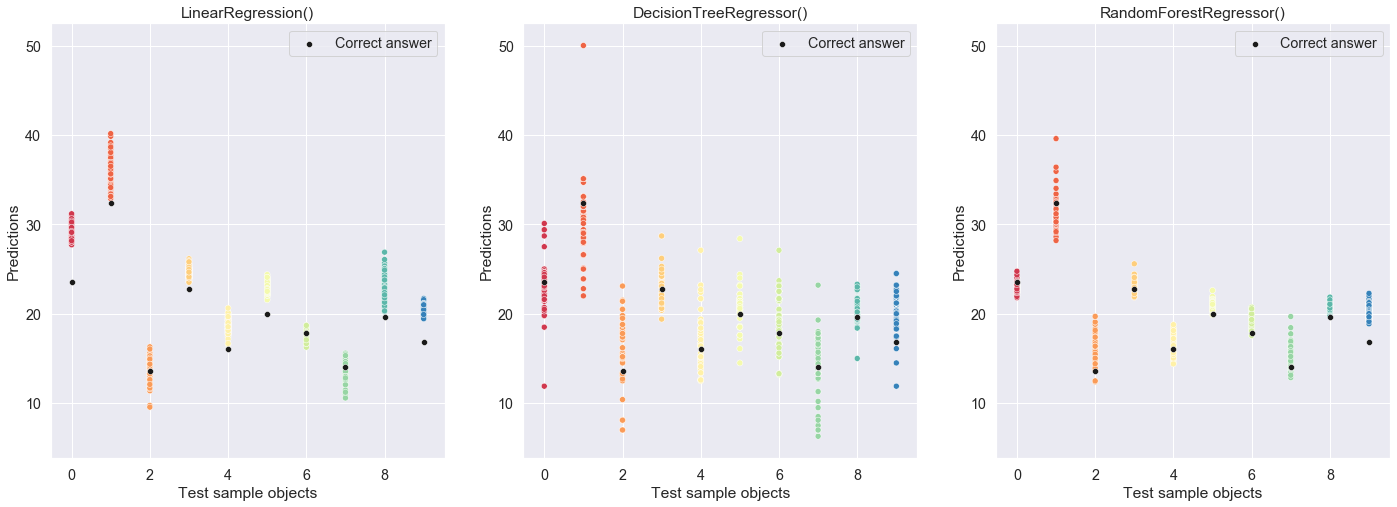

In [9]:
plt.style.use('bmh')
sns.set(font_scale = 1.3)
plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
for i, algorithm in enumerate([LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]):
    if i == 0: plot = plt.subplot(1, 3, i + 1)
    else: plt.subplot(1, 3, i + 1, sharey=plot)
    plot_predictions(algorithm, X, y, title='{}'.format(algorithm))

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

1. `LinearRegression`. What do we see? Well, все не круто. Хотя как. Это конечно мега здорово, что распределение предсказаний моделей достаточно близки к друг другу, практически без отщепенцев, особо значительных расстояний между предсказаниями моделей не наблюдается. Другими словами, разброс (variance) невелик, что согласуется с полученными ранее значениями. НО: everything before the word ‘but’ is... В том смысле, что черные точки ясно дают понять на небольшие проблемы в предсказаниях. В некоторых столбцах правильные ответы не просто находятся у края скоплений предсказаний, а даже на определенном расстоянии. Другими словами, мы получаем высокое смещение, что ожидаемо.


2. `DecisionTreeRegressor`. Как уже говорили ранее, все наоборот: скопления намного менее плотные, наблюдается сильный разброс в предсказаниях. Максимальные и минимальные значения в столбцах на относительно огромных дистанциях. В то же время, правильные ответы приходятся $\pm$ на середины данных скоплений. Не наблюдается кейсов, когда бы черная точка находилась на расстоянии от границ, редко - на самой границе. То есть, получаем более низкое смещение.


3. `RandomForestRegressor`. Вспомним, что вся прелесть случайного леса: одновременно низкие разброс и смещение (в сравнении, конечно). Видим подтверждение на графике: столбцы предсказаний плотные, скопления практически не имеют расстояний внутри себя - низкий разброс. Аналогично, черные точки практически во всех кейсах находится внутри скоплений, изредка на границе/ на расстоянии. Можно заметить, что в некотором смысле третий график отображает первые два. Это полностью синхронизируется с представленными значениями разброса и смещения по моделям.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [249]:
xaxis_pre = {'bias_1':[], 'variance_1':[], 'bias_2':[], 'variance_2':[]}
for depth in range(1, 10 + 1):
    b, v, _ =  compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y)
    xaxis_pre['bias_1'].append(b)
    xaxis_pre['variance_1'].append(v)
for feat in range(1, X.shape[1] + 1):
    b, v, _ =  compute_biase_variance(DecisionTreeRegressor(max_features=feat), X, y)
    xaxis_pre['bias_2'].append(b)
    xaxis_pre['variance_2'].append(v)

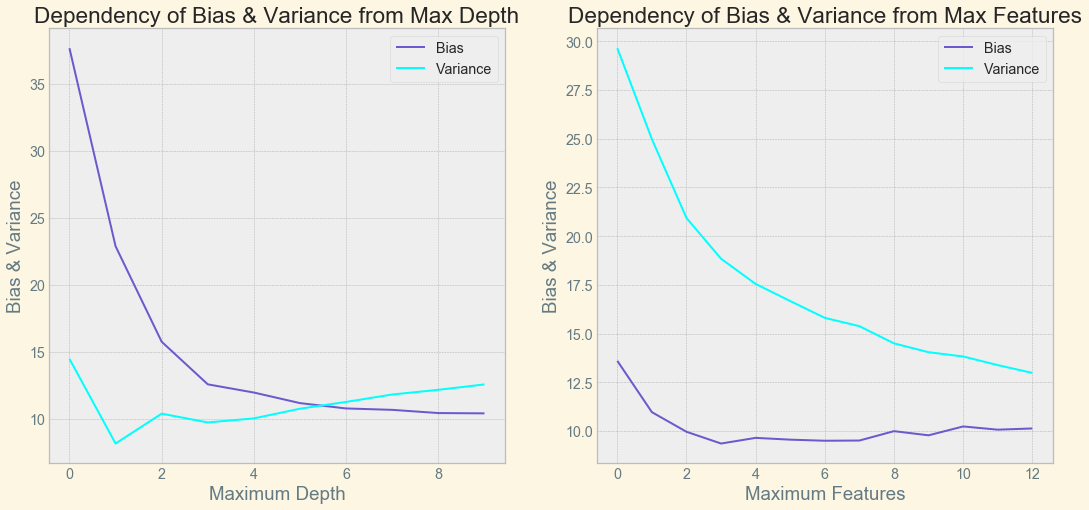

In [264]:
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
ax[0].plot(xaxis_pre['bias_1'], label='Bias', color='slateblue')
ax[0].plot(xaxis_pre['variance_1'], label='Variance', color='cyan')
ax[0].set(xlabel='Maximum Depth', ylabel='Bias & Variance', title='Dependency of Bias & Variance from Max Depth')
ax[0].legend()

ax[1].plot(xaxis_pre['bias_2'], label='Bias', color='slateblue')
ax[1].plot(xaxis_pre['variance_2'], label='Variance', color='cyan')
ax[1].set(xlabel='Maximum Features', ylabel='Bias & Variance', title='Dependency of Bias & Variance from Max Features')
ax[1].legend()

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [246]:
xaxis = {'bias_1':[], 'variance_1':[], 'bias_2':[], 'variance_2':[]}
progress_bar = tqdm_notebook(2**np.arange(1, 10))
for i, number in enumerate(progress_bar):
    b, v, _ =  compute_biase_variance(RandomForestRegressor(n_estimators=number), X, y)
    xaxis['bias_1'].append(b)
    xaxis['variance_1'].append(v)
    progress_bar.set_description('processed RF: %d' % (1 + i))

    b, v, _ =  compute_biase_variance(GradientBoostingRegressor(n_estimators=number), X, y)
    xaxis['bias_2'].append(b)
    xaxis['variance_2'].append(v)
    progress_bar.set_description('processed GB: %d' % (1 + i))
    progress_bar.update(1)

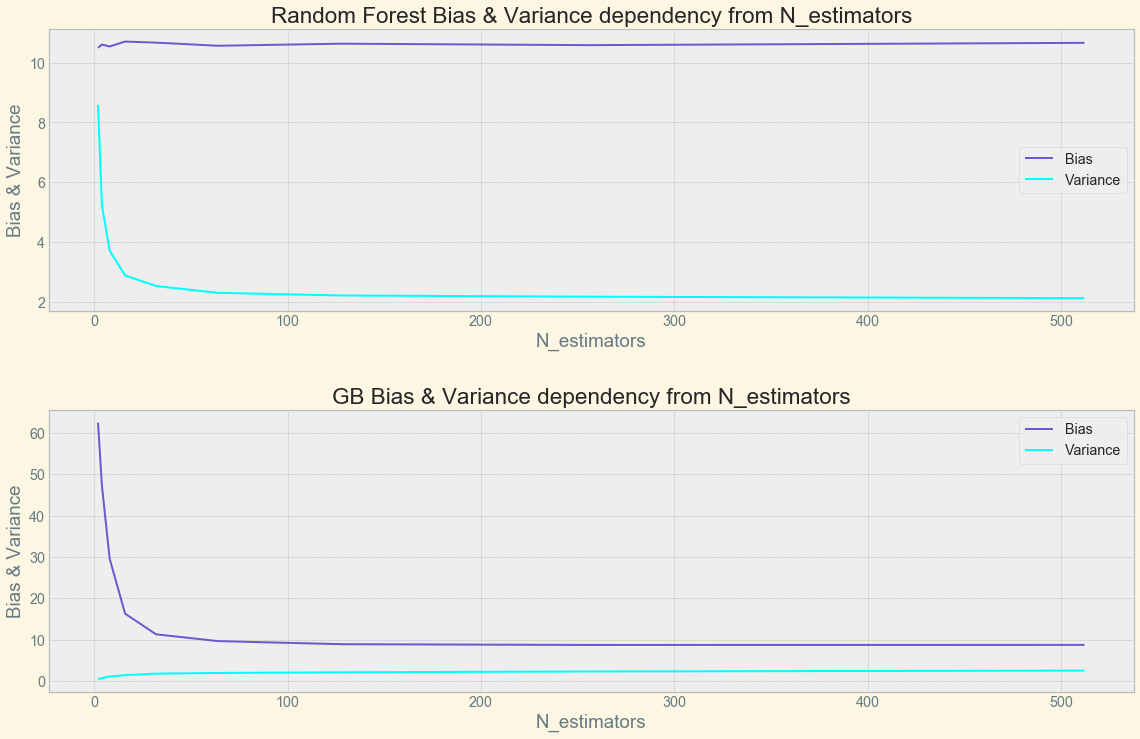

In [265]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
ax[0].plot(2**np.arange(1, 10), xaxis['bias_1'], label='Bias', color='slateblue')
ax[0].plot(2**np.arange(1, 10), xaxis['variance_1'], label='Variance', color='cyan')
ax[0].set(xlabel='N_estimators', ylabel='Bias & Variance', title='Random Forest Bias & Variance dependency from N_estimators')
ax[0].legend()

ax[1].plot(2**np.arange(1, 10), xaxis['bias_2'], label='Bias', color='slateblue')
ax[1].plot(2**np.arange(1, 10), xaxis['variance_2'], label='Variance', color='cyan')
ax[1].set(xlabel='N_estimators', ylabel='Bias & Variance', title='GB Bias & Variance dependency from N_estimators')
ax[1].legend()

plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

1. Graph №1 **BV from Maximum Depth**


Видим, что, во-первых, огромные значения смещения с ростом анализируемого параметра падают, выходя на некоторого рода асимптоту в районе 10, а во-вторых, разброс после достижения минимума на глубине равной единице, начинают немонотонный рост, по итоге даже превышая изначально столь большие значения bias. Ну, обстановка неплоха. Однако с чем же все связано? Стремительное падение смещения с вершины обусловлено тем, что при маленькой глубине дерева модель практически не может как-то подстроиться под обучающую выборку. Напротив, рост глубины означает увеличение вариаций предикатов и листьев, что позволяет все больше и больше видоизменяться в сторону полного повторения выборки. В итоге же, дерево отражает максимальным возможным образом обучающую выборку, тем самым не нуждаясь в большей глубине (поэтому выходим на плато). Вернемся теперь к разбросу. Понятное дело, что при небольшой глубине особых вариантов давать кардинально разные предсказания не будет вне зависимости от подаваемых данных. Тем не менее, с углублением модели растет вариативность, происходит переобучение. Таким образом, каждая модель оказывается в полной зависимости от обучающих данных.


2. Graph №2 **BV from Maximum Features**

Увеличивая значения параметра `max_feature` мы тем самым позволяем модели исследователь все большее число признаков при разбиении. Другими словами, задавая слишком маленькое значение здесь, мы автоматически приводим ситуацию к высокому разбросу. Модели не учитывают всех подаваемых данных, опираются лишь на некоторые признаки, вследствие чего дают разные предсказания. С приближение к исходному числу признаков модели становятся все более похожими друг на друга, вследствие чего падает значение разброса. В свою очередь, столь явной динамики для смещения нет. Его общие значения предстают не значительными, минимум достигается при значении параметра равным 3. Таким образом, можно предположить, что в определенный момент модели получают ключевые для прогноза признаки, по факту выдавая правильное значение. При этом с увеличением параметра модели начинают включать в себе все менее важные параметры, по итогу преводя к увеличивающемуся смещению.


3. Graph №3 **Random Forest's BV from N_estimators**

Во-первых, очевидным исходом оказалось практически константное значение смещения: теоретически обусловлен тот факт, что вне зависисмости от количества базовых моделей итоговое смещение не подвержено изменениям. Как бы не было много моделей, проблемы со смещением случайного леса не могут быть изменены и будут сохраняться. Следовательно, достаточно логичен следующий пункт о пользе увеличения параметра `n_estimators` для разброса. С ростом числа моделей мы видим падение графика, в определенный момент приблизившегося к своей асимптоте в районе двух. Таким образом, можно сделать вывод, что параметр действительно влияет на разброс, но до определенного момента, после которого особых изменений не наблюдается. В отличии от временных затрат, по итогу достигающих достаточно серьезных значений. Это также логично, ведь больще базовых моделей случайного леса будет означать напрямую меньший разброс и большую плотность предсказаний.

4. Graph №4 **Gradient Boost's BV from N_estimators**

Сразу можно отметить резкое падение смещения до определенного момента, после которого улучшения наблюдаются, но незначительные (в особенности учитывая вычислительные сложности). Логика здесь следующая: последвоательно выстраивая модели, мы все лучше приближаемся к оптимальной модели, исправляя прошлые ошибки. Однако опять же, общие проблемы базовых моделей все равно не могут быть полностью решены, а потому польза в контексте смещения от GB заметна, но ограничена. В то же время, можно наблюдать незначительный рост разброса: мы все больше переобучаемся, начиная учитывать тонкие особенности обучающей выборки, вследствие чего последующие модели все больше разняться с изначальными, пытавшимися анализировать обший тренд.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

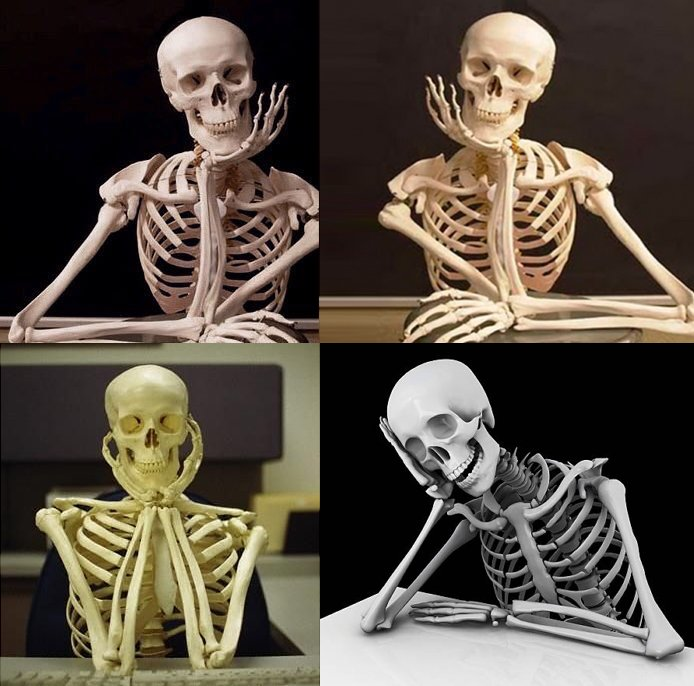